### See how decodable previous action is on next trial
- Look at a few periods
    - previous trial feedback
    - current trial cross fixation
    - current trial action selection

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate


matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 14})



species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [3]:
torch.cuda.is_available()

True

In [4]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

### Find, filter for trials where Choice Duration > 300ms

In [5]:
valid_beh["ChoiceDuration"] = valid_beh.FeedbackEncode - 800 - valid_beh.StimOnset

In [6]:
valid_beh_long_choice = valid_beh[valid_beh.ChoiceDuration > 300]
len(valid_beh_long_choice)

1188

In [7]:
prev_trials = valid_beh_long_choice.TrialNumber - 1
prev_valid_trials = valid_beh[valid_beh.TrialNumber.isin(prev_trials)]
next_valid_trials = valid_beh[valid_beh.TrialNumber.isin(prev_valid_trials.TrialNumber + 1)]

prev_shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(prev_valid_trials)
prev_shuffled_next_trial = prev_shuffled_card_idxs.copy(deep=True)
prev_shuffled_next_trial["TrialNumber"] = prev_shuffled_card_idxs.TrialNumber + 1

### Finally write some helper functions

In [22]:
def train_model(firing_rates, card_idxs, pre_int, post_int, bin_size, name, event_name):
    num_neurons = len(firing_rates.UnitID.unique())
    labels = np.sort(card_idxs.ItemChosen.unique())
    init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_values": 12}
    # init_params = {"n_inputs": num_neurons, "n_values": 12}

    trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
    wrapped = ModelWrapper(ValueNormedDropoutModel, init_params, trainer, labels)
    # wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = card_idxs.rename(columns={"ItemChosen": "Feature"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    outputs = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, (pre_int + post_int) / 1000, bin_size / 1000), random_splitter, cards=card_idxs
    )
    io_utils.save_model_outputs(
        name, 
        f"{pre_int}_{event_name}_{post_int}",
        "random_split",
        outputs
    )

### Look at previous trial's decodability during feedback as sanity check

In [6]:
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_1300_FeedbackOnset_1500_50_bins.pickle")
firing_rates = firing_rates[firing_rates.TrialNumber.isin(prev_valid_trials.TrialNumber)]

In [ ]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(prev_shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_values": 12}
# init_params = {"n_inputs": num_neurons, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedDropoutModel, init_params, trainer, labels)
# wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = prev_shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.05), random_splitter, cards=prev_shuffled_card_idxs
)
io_utils.save_model_outputs(
    "action_valid_trials", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

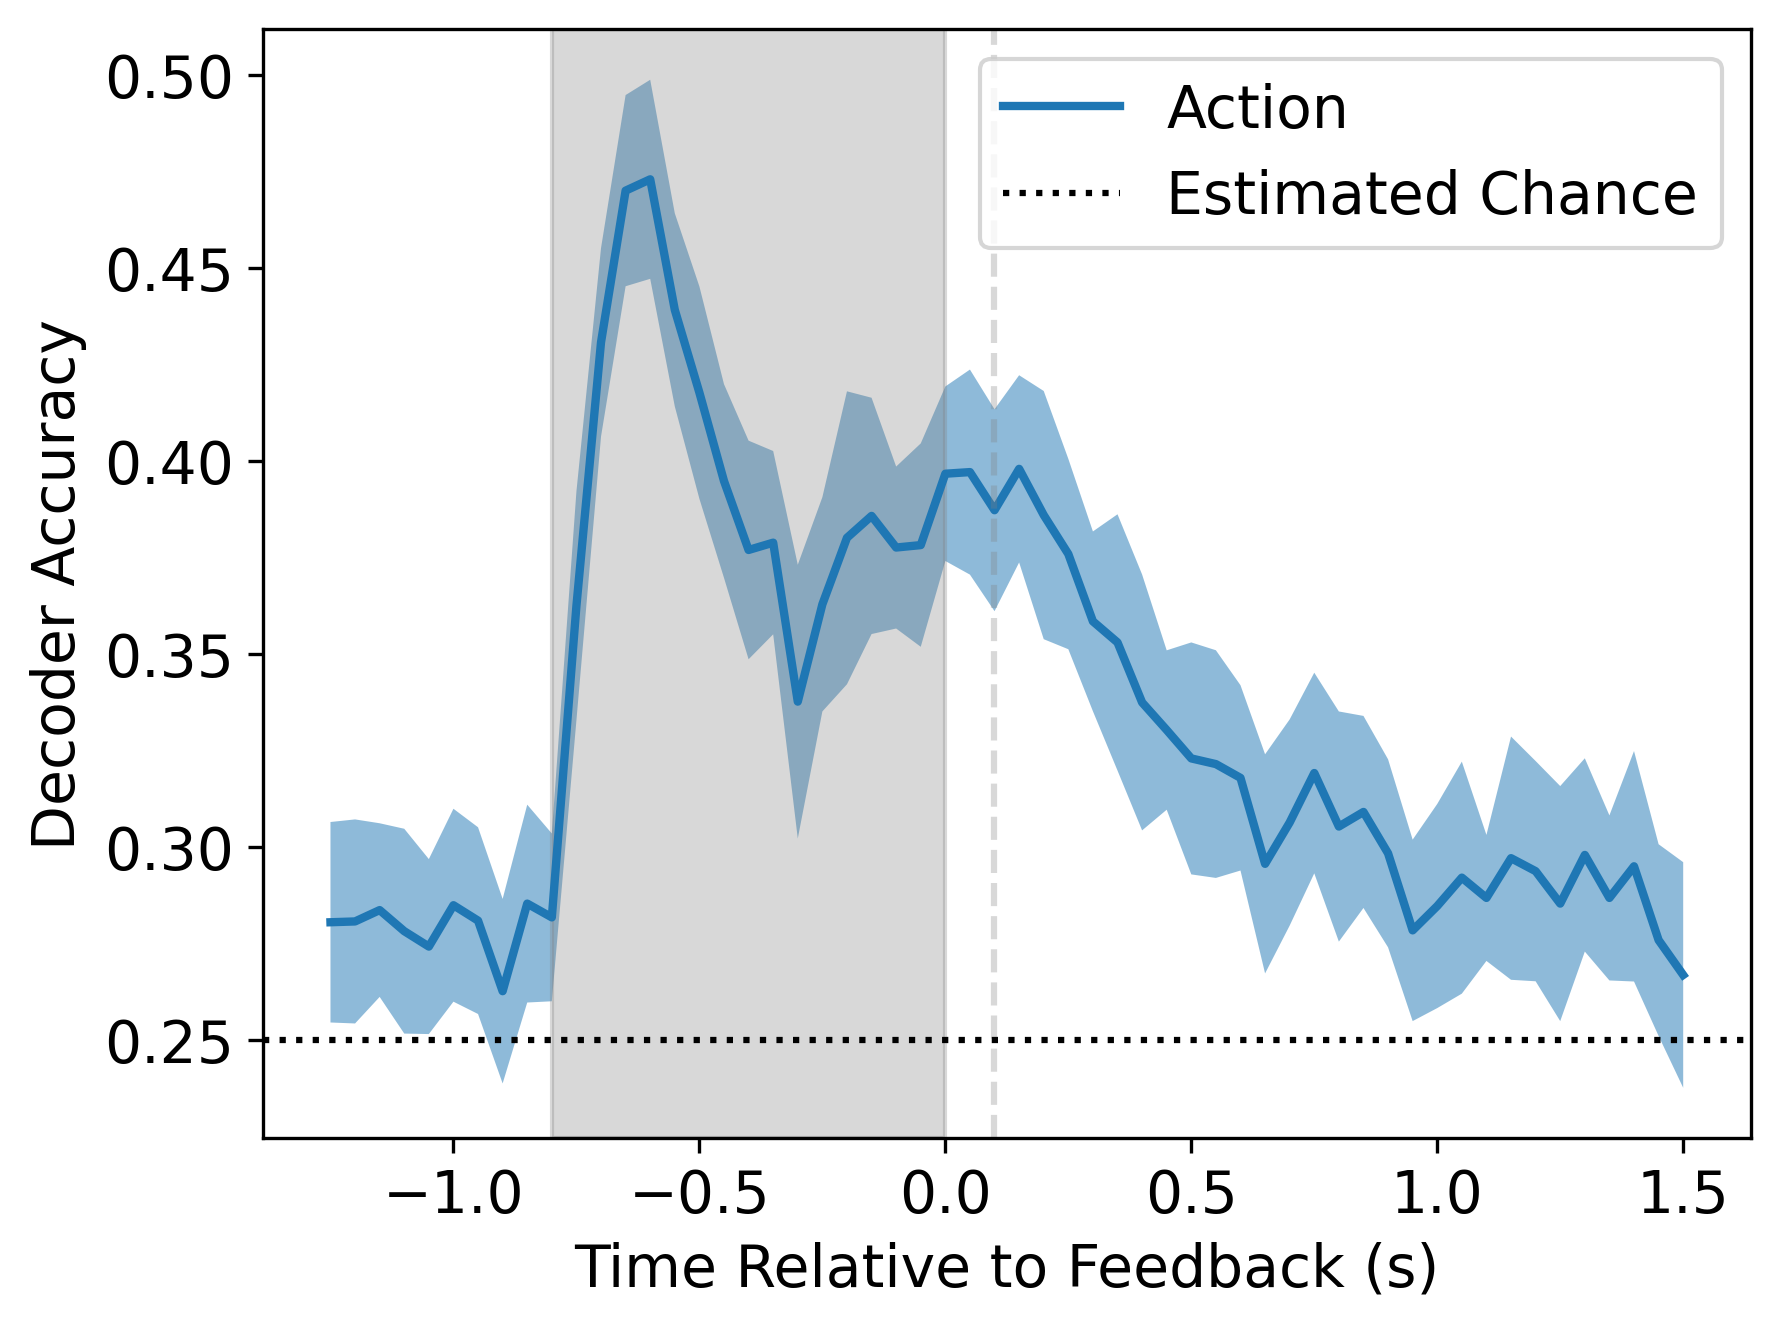

In [10]:
_, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
    "action_valid_trials", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 1.5, 0.05,
    ax,
    label="Action",
    right_align=True, 
    # color='black'
)

ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})

### Look at next trial's decodability during cross fixation

In [85]:
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_150_FixationOnCross_350_50_bins.pickle")
firing_rates = firing_rates[firing_rates.TrialNumber.isin(next_valid_trials.TrialNumber)]

In [86]:
pre_interval = 150
post_interval = 350

num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(prev_shuffled_next_trial.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_values": 12}
# init_params = {"n_inputs": num_neurons, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedDropoutModel, init_params, trainer, labels)
# wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = prev_shuffled_next_trial.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 0.5, 0.05), random_splitter, cards=prev_shuffled_next_trial
)
io_utils.save_model_outputs(
    "action_next_trials", 
    f"{pre_interval}_crossfixation_{post_interval}",
    "random_split",
    outputs
)

cuda
Evaluating for bin 0.0
Evaluating for bin 0.05
Evaluating for bin 0.1
Evaluating for bin 0.15000000000000002
Evaluating for bin 0.2
Evaluating for bin 0.25
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.35000000000000003
Evaluating for bin 0.4
Evaluating for bin 0.45


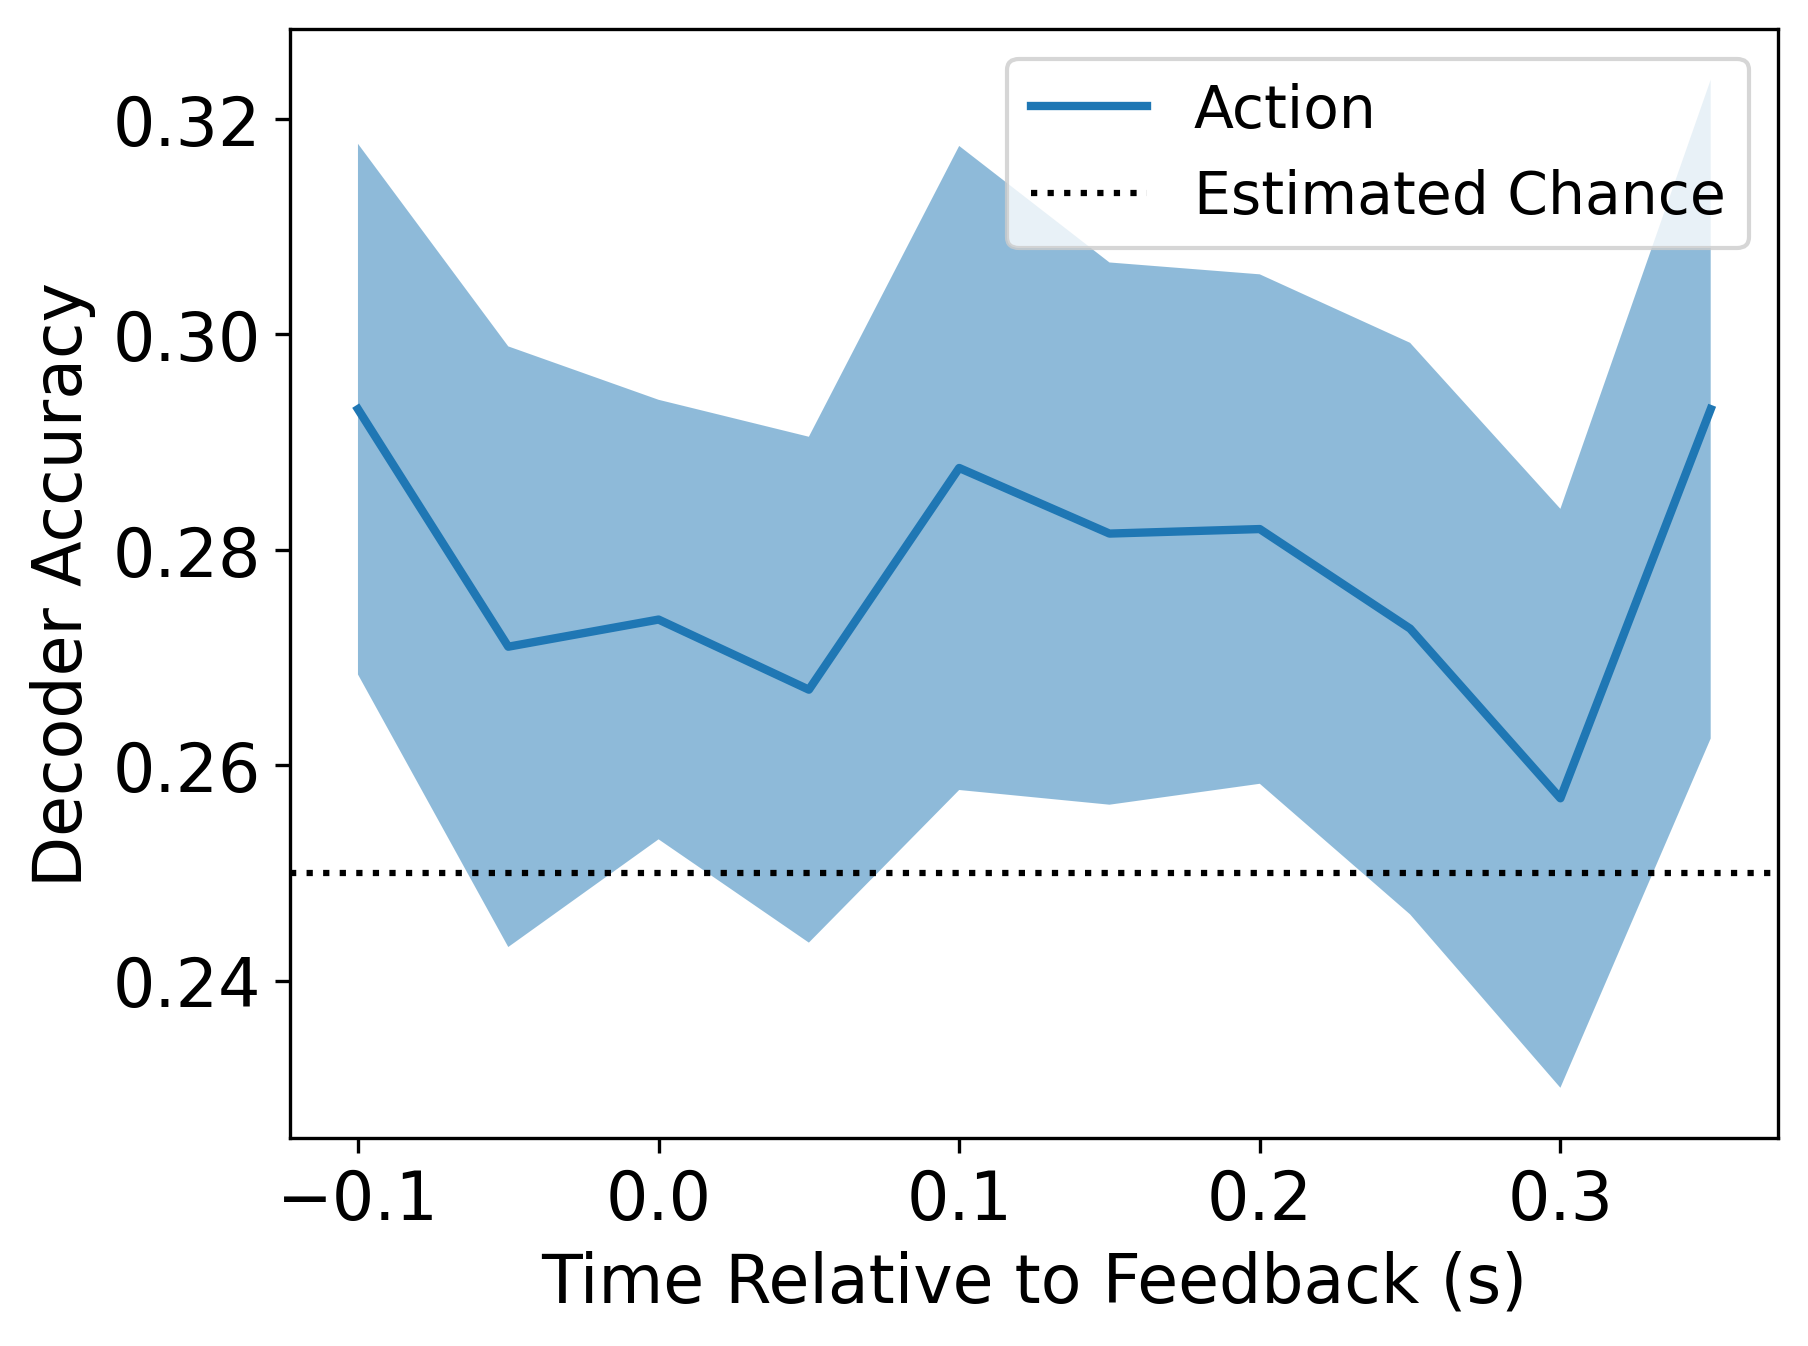

In [42]:
_, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
    "action_next_trials", 
    f"{pre_interval}_crossfixation_{post_interval}",
    "random_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    0.15, 0.35, 0.05,
    ax,
    label="Action",
    right_align=True, 
    # color='black'
)

ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})

### Look at next trial's decodability during stimulus on

In [11]:
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_200_StimOnset_300_50_bins.pickle")
firing_rates = firing_rates[firing_rates.TrialNumber.isin(next_valid_trials.TrialNumber)]

In [12]:
pre_interval = 200
post_interval = 300

num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(prev_shuffled_next_trial.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_values": 12}
# init_params = {"n_inputs": num_neurons, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedDropoutModel, init_params, trainer, labels)
# wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = prev_shuffled_next_trial.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 0.50, 0.05), random_splitter, cards=prev_shuffled_next_trial
)
io_utils.save_model_outputs(
    "action_next_trials", 
    f"{pre_interval}_stimon_{post_interval}",
    "random_split",
    outputs
)

cuda
Evaluating for bin 0.0
Evaluating for bin 0.05
Evaluating for bin 0.1
Evaluating for bin 0.15000000000000002
Evaluating for bin 0.2
Evaluating for bin 0.25
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.35000000000000003
Evaluating for bin 0.4
Evaluating for bin 0.45


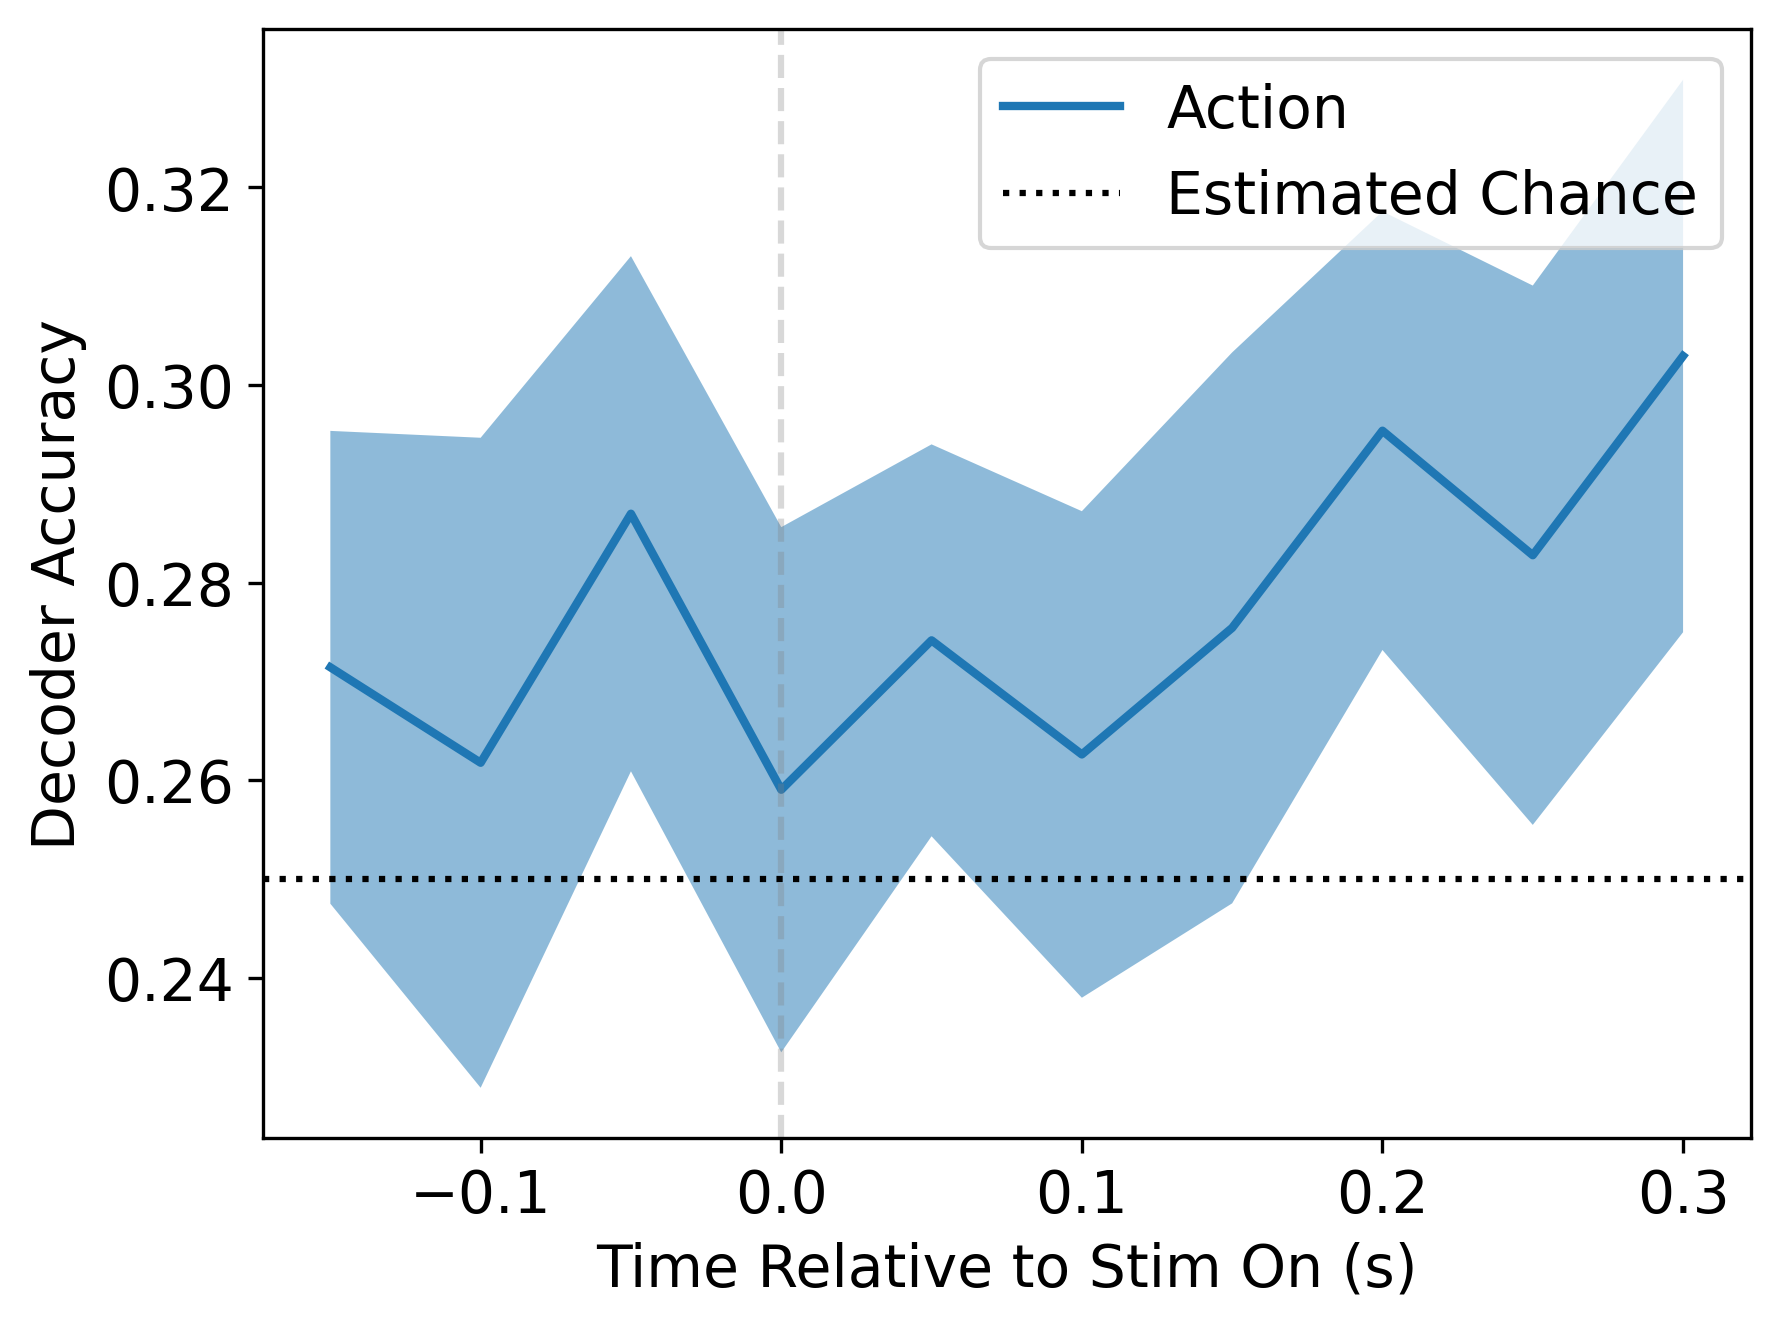

In [15]:
_, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
    "action_next_trials", 
    f"{pre_interval}_stimon_{post_interval}",
    "random_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    0.2, 0.3, 0.05,
    ax,
    label="Action",
    right_align=True, 
    # color='black'
)

ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.axvline(0, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Stim On (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})

### Plot all 3 together

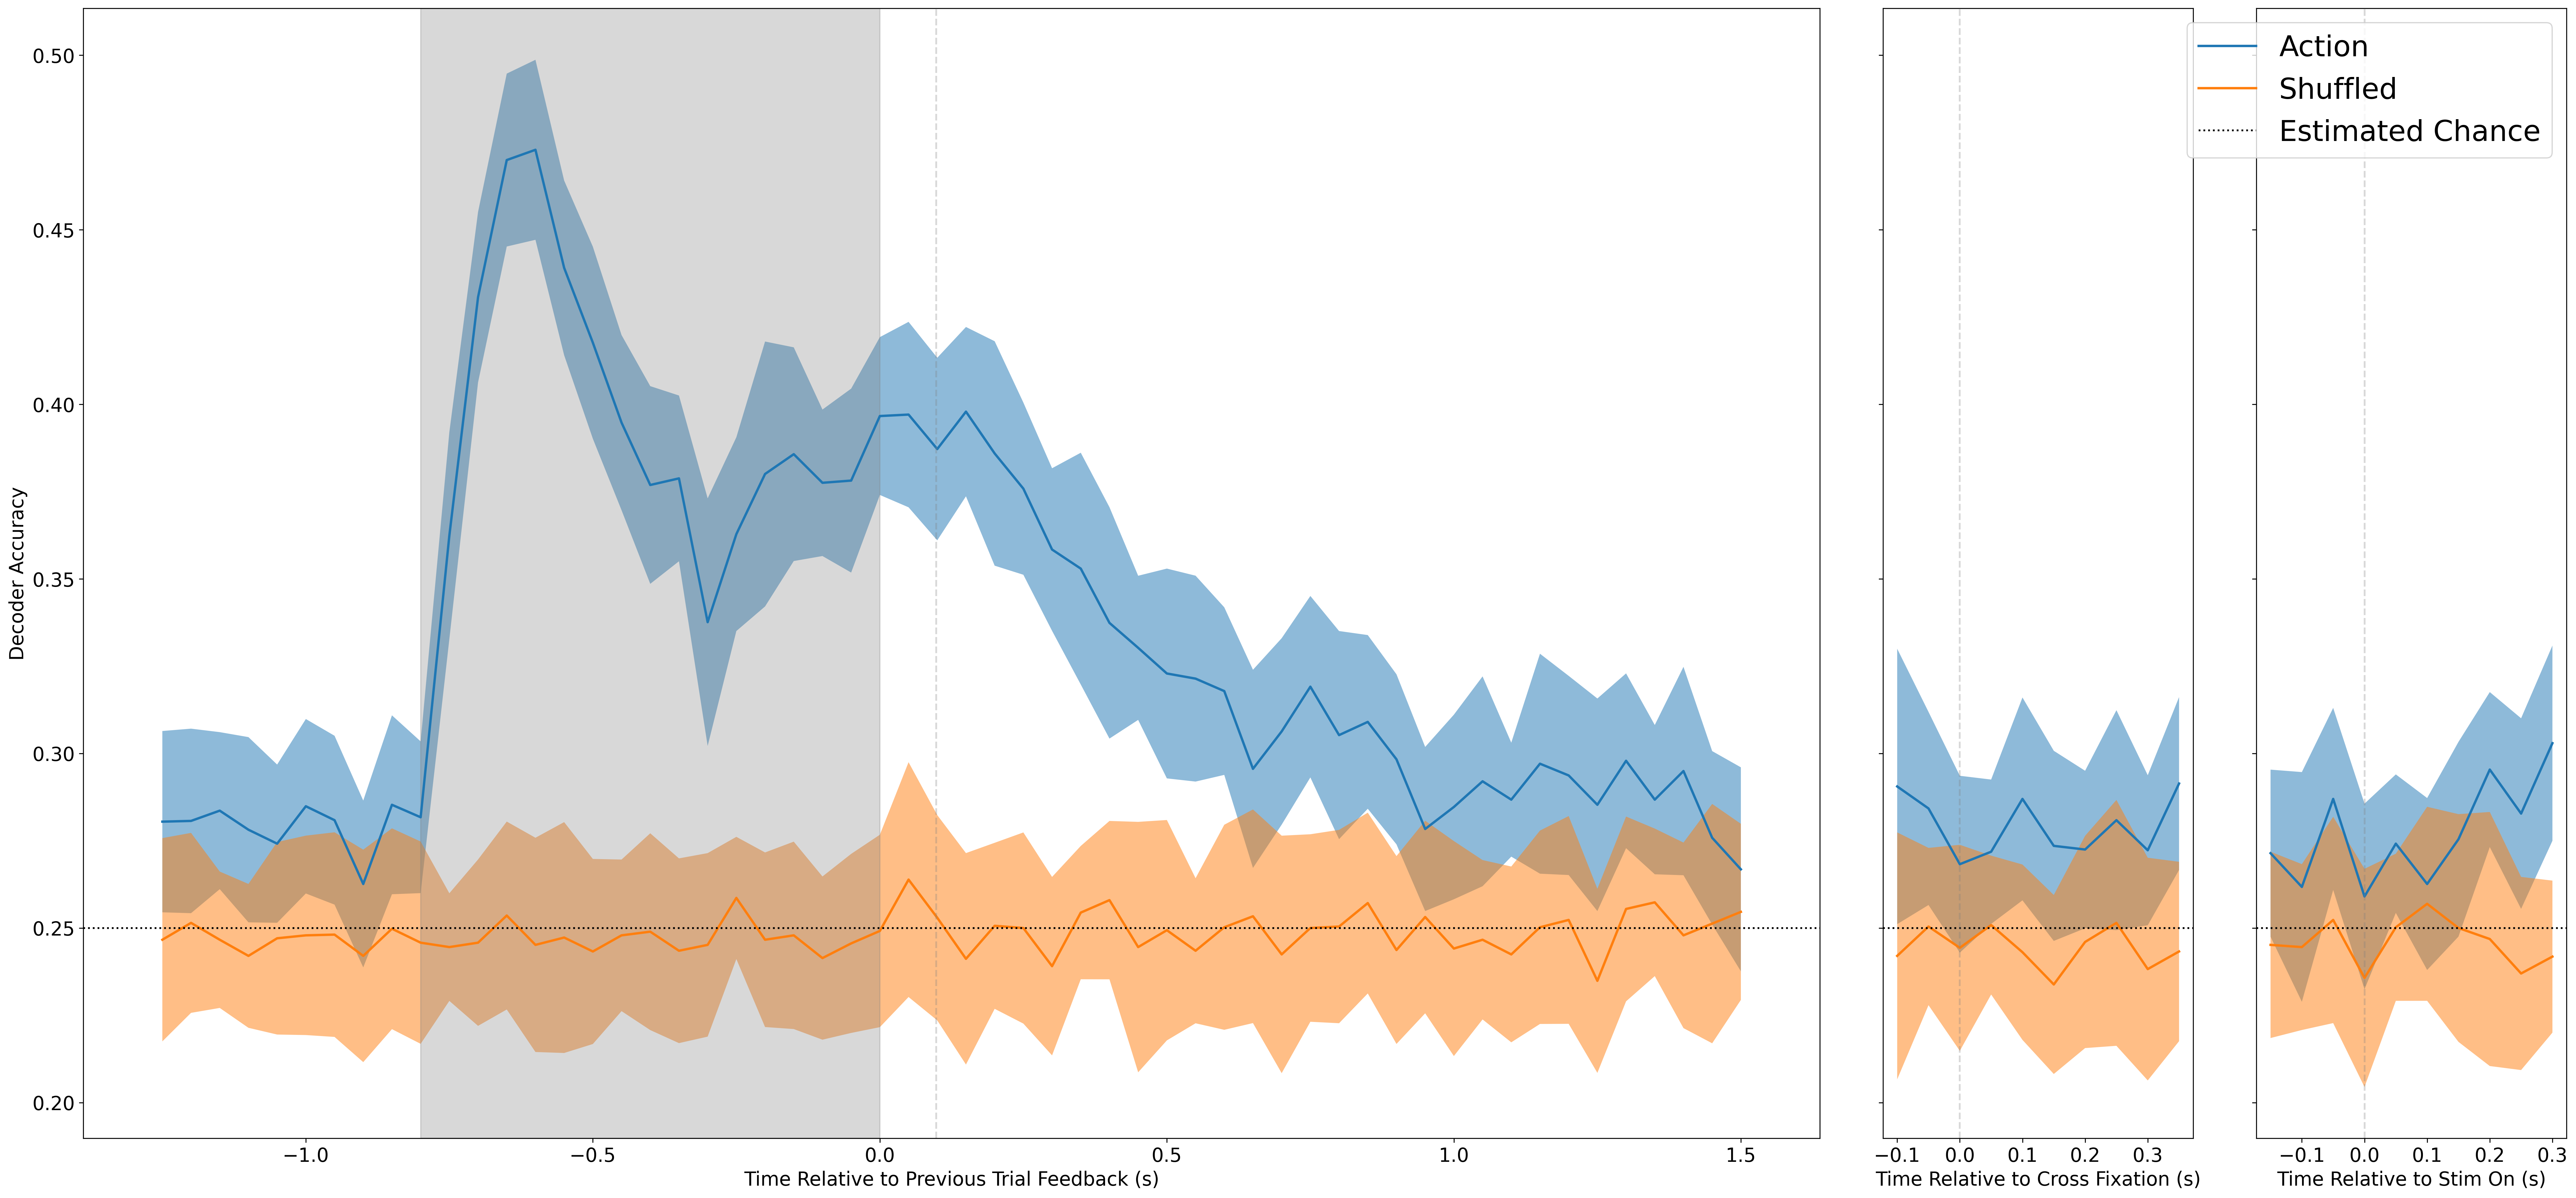

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(30, 14), sharey=True, width_ratios=[28, 5, 5])
fig.tight_layout()
matplotlib.rcParams.update({'font.size': 16})

_, prev_fb_accs, shuffled_prev_fb, _, _ = io_utils.load_model_outputs(
    "action_valid_trials", 
    f"1300_fb_1500",
    "random_split",
)

_, cross_fix_accs, shuffled_cross_fix, _, _ = io_utils.load_model_outputs(
    "action_next_trials", 
    f"150_crossfixation_350",
    "random_split",
)

_, stim_on_accs, shuffled_stim_on, _, _ = io_utils.load_model_outputs(
    "action_next_trials", 
    f"200_stimon_300",
    "random_split",
)

visualization_utils.visualize_accuracy_across_time_bins(
    prev_fb_accs,
    1.3, 1.5, 0.05,
    ax[0],
    label="Action",
    right_align=True, 
    # color='black'
)

visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_prev_fb,
    1.3, 1.5, 0.05,
    ax[0],
    label="Shuffled",
    right_align=True, 
    # color='black'
)

ax[0].axvspan(-0.8, 0, alpha=0.3, color='gray')
ax[0].axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax[0].axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax[0].set_xlabel("Time Relative to Previous Trial Feedback (s)")
ax[0].set_ylabel("Decoder Accuracy")
# ax[0].legend(prop={'size': 14})


visualization_utils.visualize_accuracy_across_time_bins(
    cross_fix_accs,
    0.15, 0.35, 0.05,
    ax[1],
    label="Action",
    right_align=True, 
    # color='black'
)

visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_cross_fix,
    0.15, 0.35, 0.05,
    ax[1],
    label="Shuffled",
    right_align=True, 
    # color='black'
)

ax[1].axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax[1].axvline(0, alpha=0.3, color='gray', linestyle='dashed')
ax[1].set_xlabel("Time Relative to Cross Fixation (s)")
# ax[1].set_ylabel("Decoder Accuracy")
# ax[1].legend(prop={'size': 14})

visualization_utils.visualize_accuracy_across_time_bins(
    stim_on_accs,
    0.2, 0.3, 0.05,
    ax[2],
    label="Action",
    right_align=True, 
    # color='black'
)


visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_stim_on,
    0.2, 0.3, 0.05,
    ax[2],
    label="Shuffled",
    right_align=True, 
    # color='black'
)
ax[2].axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax[2].axvline(0, alpha=0.3, color='gray', linestyle='dashed')
ax[2].set_xlabel("Time Relative to Stim On (s)")
# ax[2].set_ylabel("Decoder Accuracy")
ax[2].legend(prop={'size': 24})


### Split by corrects/incorrects?

In [10]:
prev_trials = valid_beh_long_choice.TrialNumber - 1
prev_valid_trials = valid_beh[valid_beh.TrialNumber.isin(prev_trials)]
next_valid_trials = valid_beh[valid_beh.TrialNumber.isin(prev_valid_trials.TrialNumber + 1)]

In [18]:
prev_valid_trials_inc = prev_valid_trials[prev_valid_trials.Response == "Incorrect"]
next_valid_trials_inc = valid_beh[valid_beh.TrialNumber.isin(prev_valid_trials_inc.TrialNumber + 1)]

prev_valid_trials_cor = prev_valid_trials[prev_valid_trials.Response == "Correct"]
# subsample correct trials so distributions match
prev_valid_trials_cor = prev_valid_trials_cor.sample(len(prev_valid_trials_inc), random_state=42)
next_valid_trials_cor = valid_beh[valid_beh.TrialNumber.isin(prev_valid_trials_cor.TrialNumber + 1)]

prev_shuffled_card_idxs_cor = behavioral_utils.get_shuffled_card_idxs(prev_valid_trials_cor)
prev_shuffled_cor_next_trial = prev_shuffled_card_idxs_cor.copy(deep=True)
prev_shuffled_cor_next_trial["TrialNumber"] = prev_shuffled_card_idxs_cor.TrialNumber + 1

prev_shuffled_card_idxs_inc = behavioral_utils.get_shuffled_card_idxs(prev_valid_trials_inc)
prev_shuffled_inc_next_trial = prev_shuffled_card_idxs_inc.copy(deep=True)
prev_shuffled_inc_next_trial["TrialNumber"] = prev_shuffled_card_idxs_inc.TrialNumber + 1

### Train models with split correct/incorrect

In [26]:
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_1300_FeedbackOnset_1500_50_bins.pickle")

In [14]:
# correct, previous feedback
train_model(firing_rates, prev_shuffled_card_idxs_cor, 1300, 1500, 50, "action_valid_trials_cor", "fb")


In [ ]:
# incorrect, previous feedback
train_model(firing_rates, prev_shuffled_card_idxs_inc, 1300, 1500, 50, "action_valid_trials_inc", "fb")


In [ ]:
# correct/incorrect, next trial cross fixation
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_150_FixationOnCross_350_50_bins.pickle")
train_model(firing_rates, prev_shuffled_cor_next_trial, 150, 350, 50, "action_next_trials_cor", "crossfixation")
train_model(firing_rates, prev_shuffled_inc_next_trial, 150, 350, 50, "action_next_trials_inc", "crossfixation")

In [ ]:
# correct/incorrect, next trial stimulus on
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_200_StimOnset_300_50_bins.pickle")
train_model(firing_rates, prev_shuffled_cor_next_trial, 200, 300, 50, "action_next_trials_cor", "stimon")
train_model(firing_rates, prev_shuffled_inc_next_trial, 200, 300, 50, "action_next_trials_inc", "stimon")

### Plot everything at once

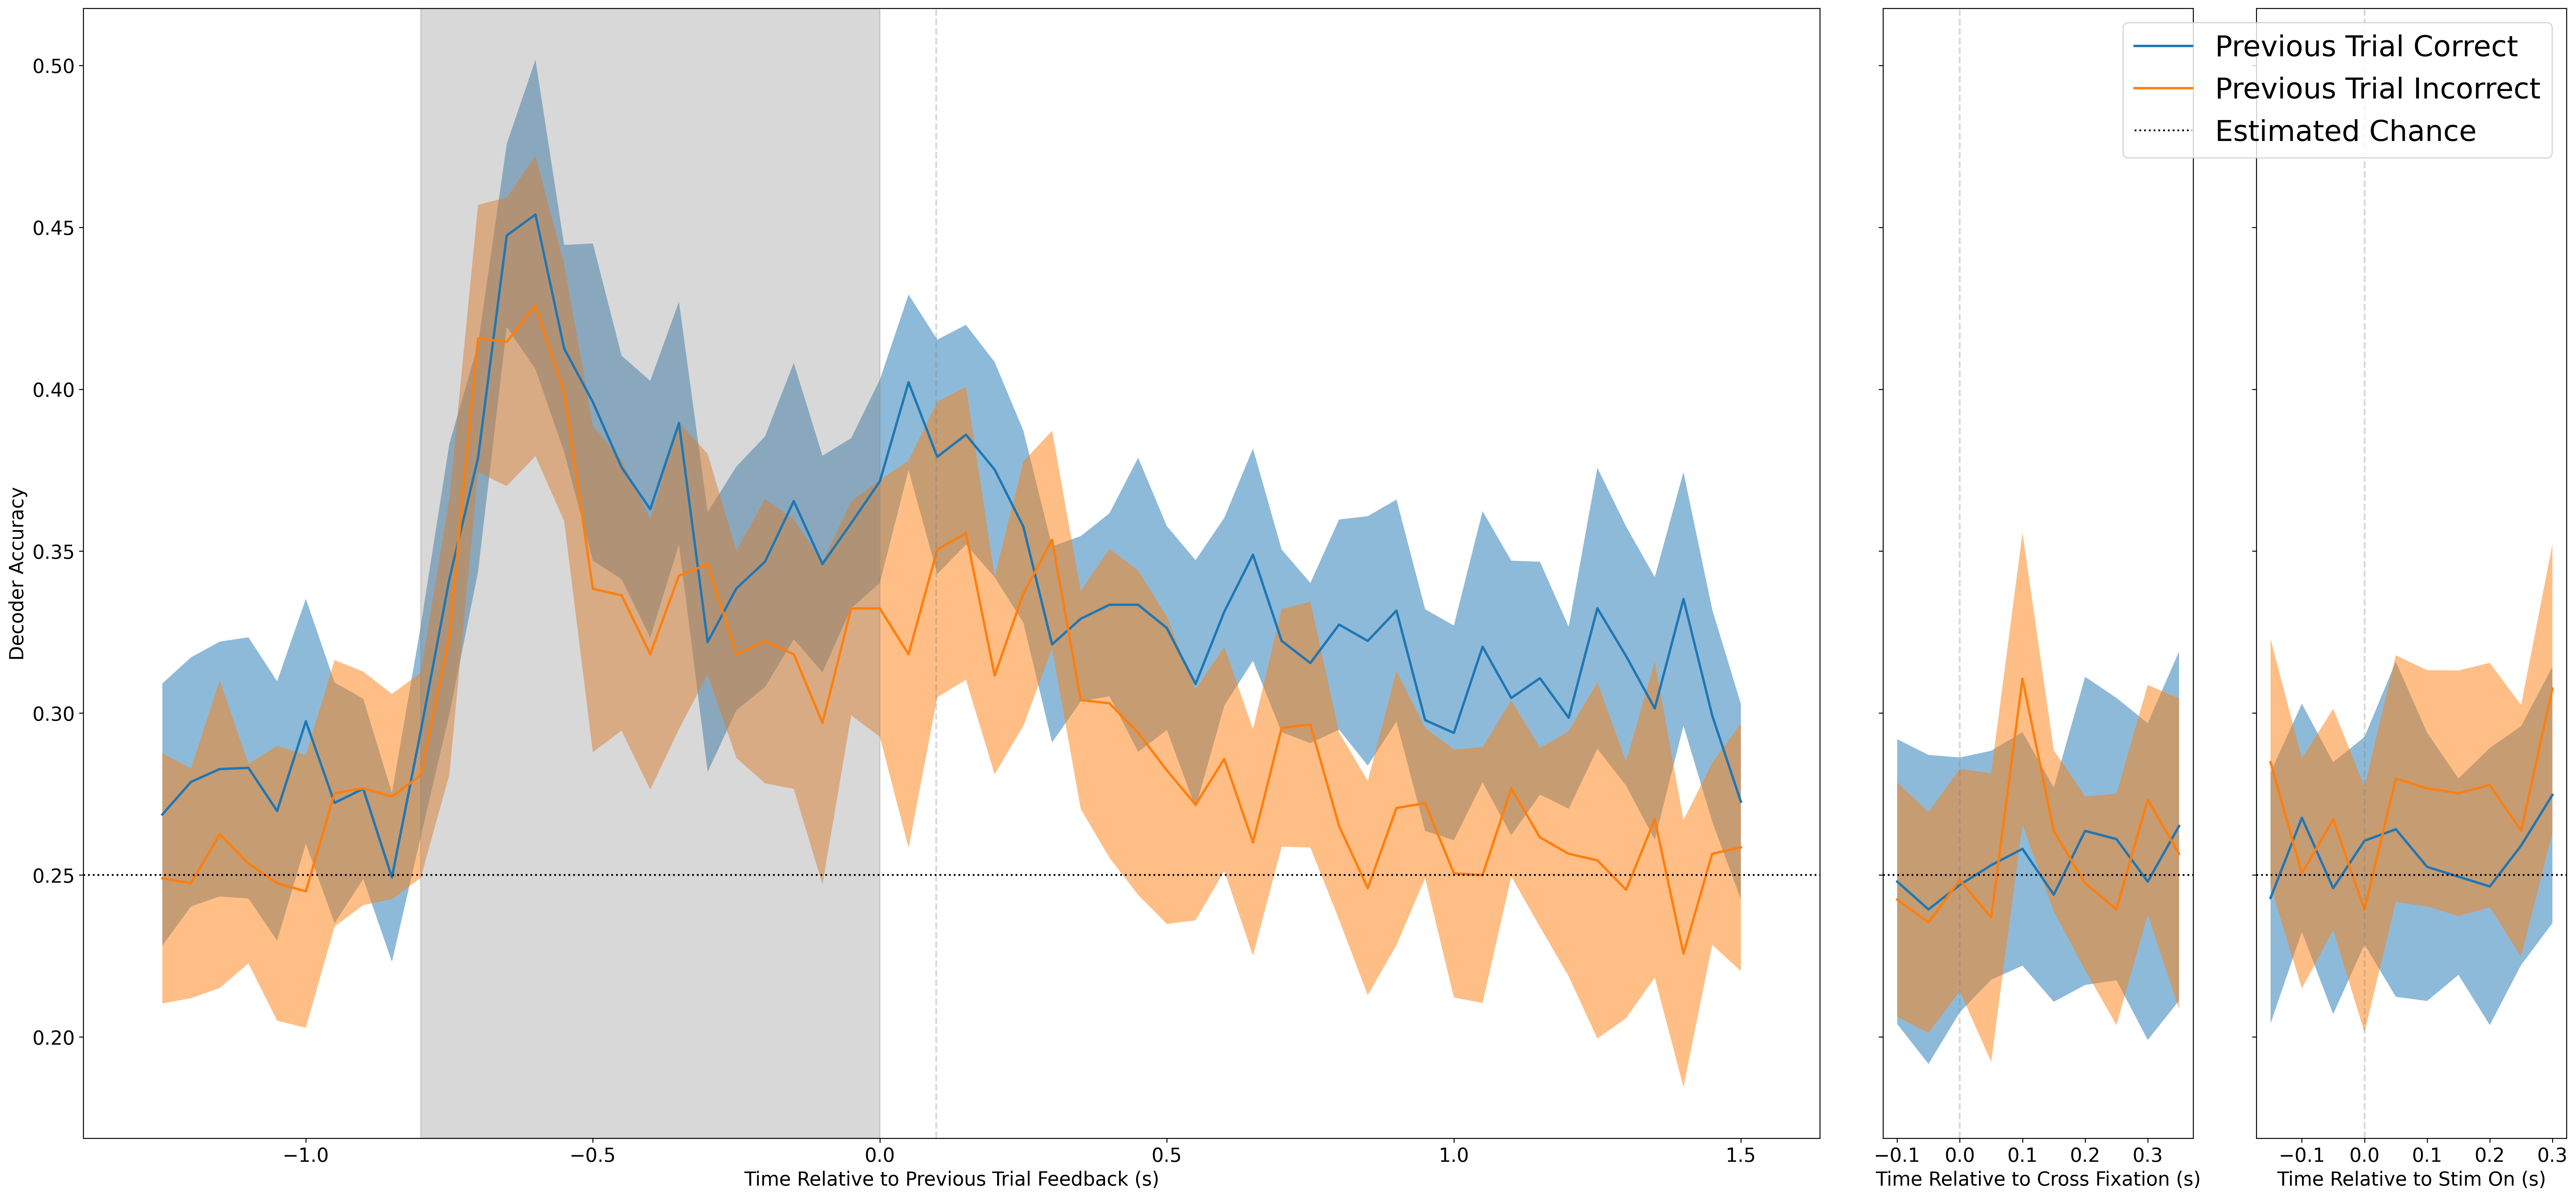

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(30, 14), sharey=True, width_ratios=[28, 5, 5])
fig.tight_layout()
matplotlib.rcParams.update({'font.size': 16})

_, prev_fb_accs_cor, _, _, _ = io_utils.load_model_outputs(
    "action_valid_trials_cor", 
    f"1300_fb_1500",
    "random_split",
)

_, prev_fb_accs_inc, _, _, _ = io_utils.load_model_outputs(
    "action_valid_trials_inc", 
    f"1300_fb_1500",
    "random_split",
)

_, cross_fix_accs_cor, _, _, _ = io_utils.load_model_outputs(
    "action_next_trials_cor", 
    f"150_crossfixation_350",
    "random_split",
)

_, cross_fix_accs_inc, _, _, _ = io_utils.load_model_outputs(
    "action_next_trials_inc", 
    f"150_crossfixation_350",
    "random_split",
)

_, stim_on_accs_cor, _, _, _ = io_utils.load_model_outputs(
    "action_next_trials_cor", 
    f"200_stimon_300",
    "random_split",
)

_, stim_on_accs_inc, _, _, _ = io_utils.load_model_outputs(
    "action_next_trials_inc", 
    f"200_stimon_300",
    "random_split",
)

visualization_utils.visualize_accuracy_across_time_bins(
    prev_fb_accs_cor,
    1.3, 1.5, 0.05,
    ax[0],
    label="Correct",
    right_align=True, 
    # color='black'
)

visualization_utils.visualize_accuracy_across_time_bins(
    prev_fb_accs_inc,
    1.3, 1.5, 0.05,
    ax[0],
    label="Incorrect",
    right_align=True, 
    # color='black'
)

ax[0].axvspan(-0.8, 0, alpha=0.3, color='gray')
ax[0].axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax[0].axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax[0].set_xlabel("Time Relative to Previous Trial Feedback (s)")
ax[0].set_ylabel("Decoder Accuracy")
# ax[0].legend(prop={'size': 14})


visualization_utils.visualize_accuracy_across_time_bins(
    cross_fix_accs_cor,
    0.15, 0.35, 0.05,
    ax[1],
    label="Correct",
    right_align=True, 
    # color='black'
)

visualization_utils.visualize_accuracy_across_time_bins(
    cross_fix_accs_inc,
    0.15, 0.35, 0.05,
    ax[1],
    label="Incorrect",
    right_align=True, 
    # color='black'
)

ax[1].axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax[1].axvline(0, alpha=0.3, color='gray', linestyle='dashed')
ax[1].set_xlabel("Time Relative to Cross Fixation (s)")
# ax[1].set_ylabel("Decoder Accuracy")
# ax[1].legend(prop={'size': 14})

visualization_utils.visualize_accuracy_across_time_bins(
    stim_on_accs_cor,
    0.2, 0.3, 0.05,
    ax[2],
    label="Previous Trial Correct",
    right_align=True, 
    # color='black'
)


visualization_utils.visualize_accuracy_across_time_bins(
    stim_on_accs_inc,
    0.2, 0.3, 0.05,
    ax[2],
    label="Previous Trial Incorrect",
    right_align=True, 
    # color='black'
)
ax[2].axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax[2].axvline(0, alpha=0.3, color='gray', linestyle='dashed')
ax[2].set_xlabel("Time Relative to Stim On (s)")
# ax[2].set_ylabel("Decoder Accuracy")
ax[2].legend(prop={'size': 24})
